                 y       client        close     price_am     price_pm
count  2101.000000  2101.000000  2101.000000  2101.000000  2101.000000
mean     34.096621     0.098049     0.012851     0.614469     0.390766
std      17.476234     0.297451     0.112658     1.127940     0.975456
min       0.000000     0.000000     0.000000    -1.000000    -1.000000
25%      21.000000     0.000000     0.000000     0.000000     0.000000
50%      32.000000     0.000000     0.000000     0.000000     0.000000
75%      45.000000     0.000000     0.000000     1.000000     1.000000
max     109.000000     1.000000     1.000000     5.000000     5.000000
price_am    28
price_pm    28
dtype: int64


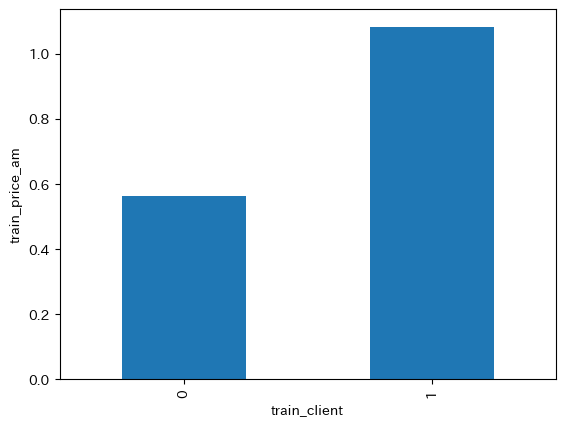

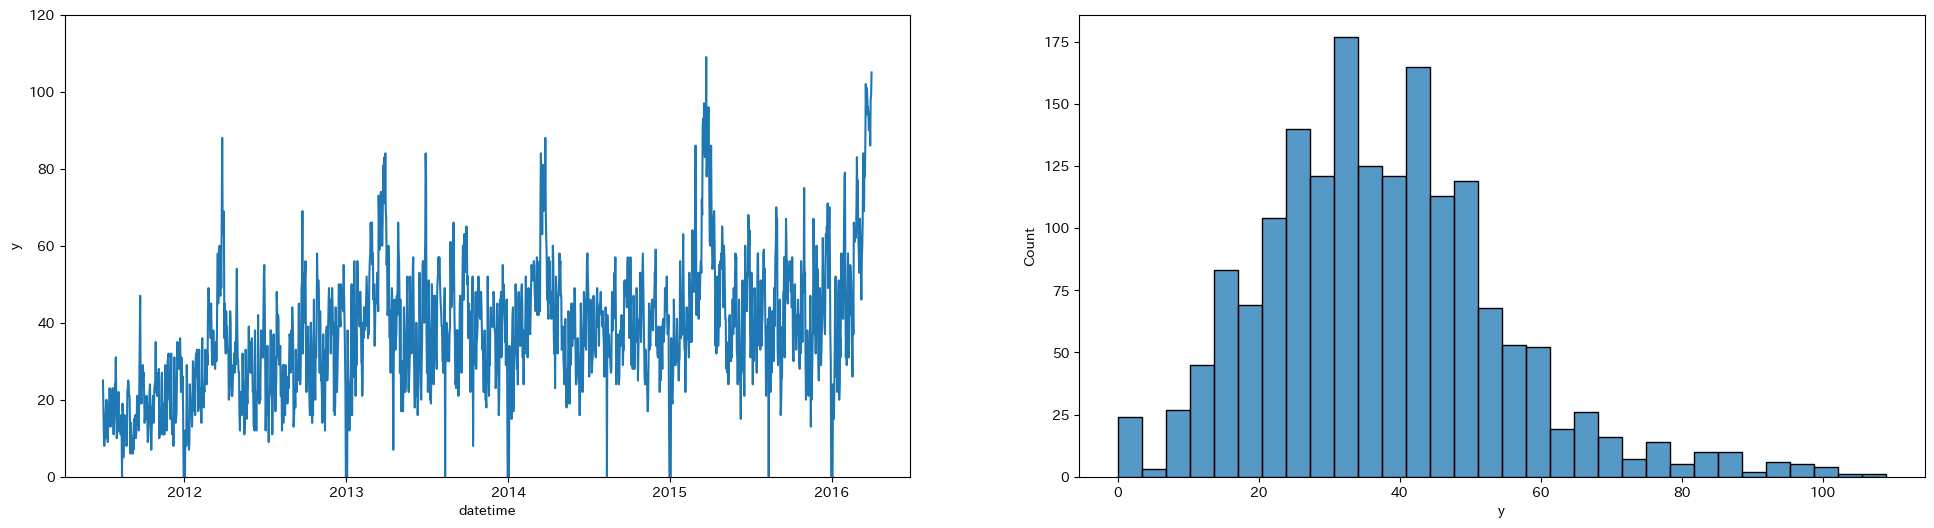

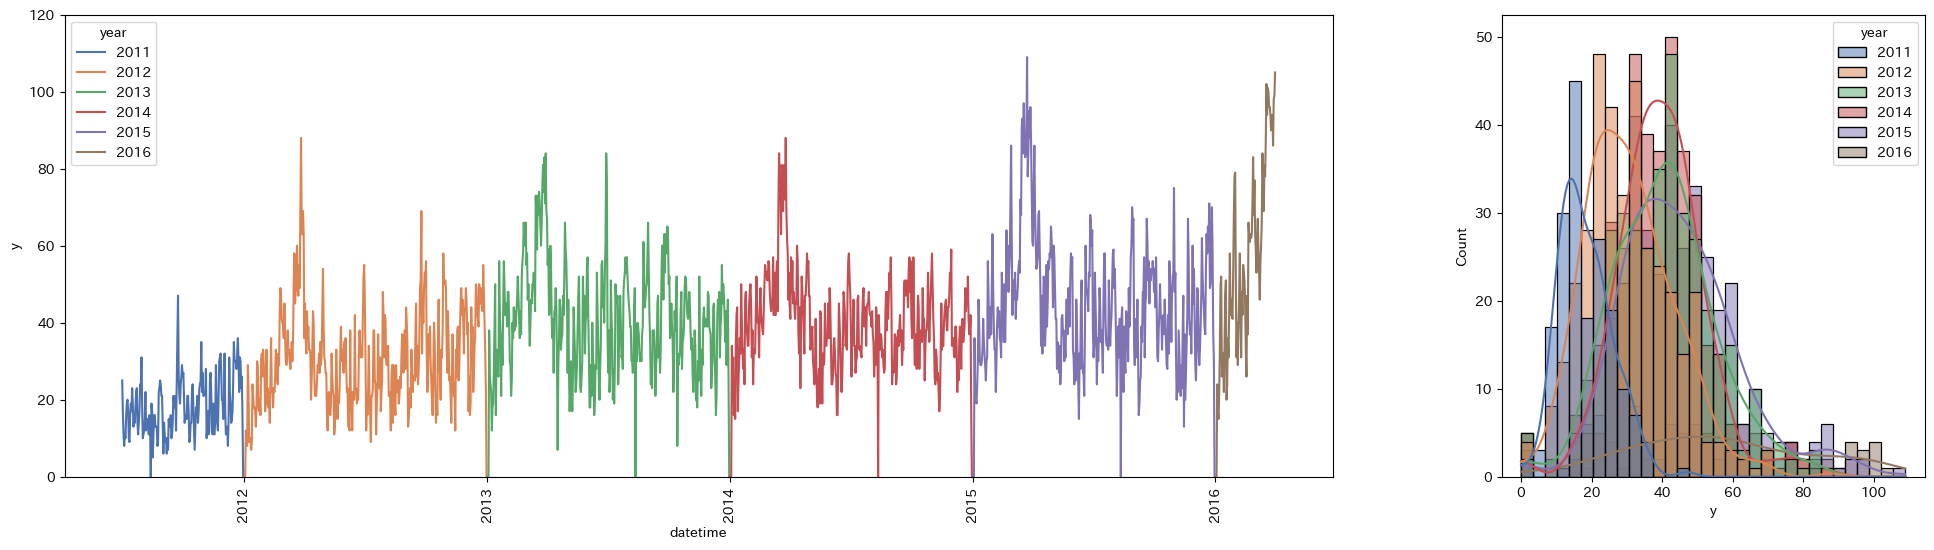

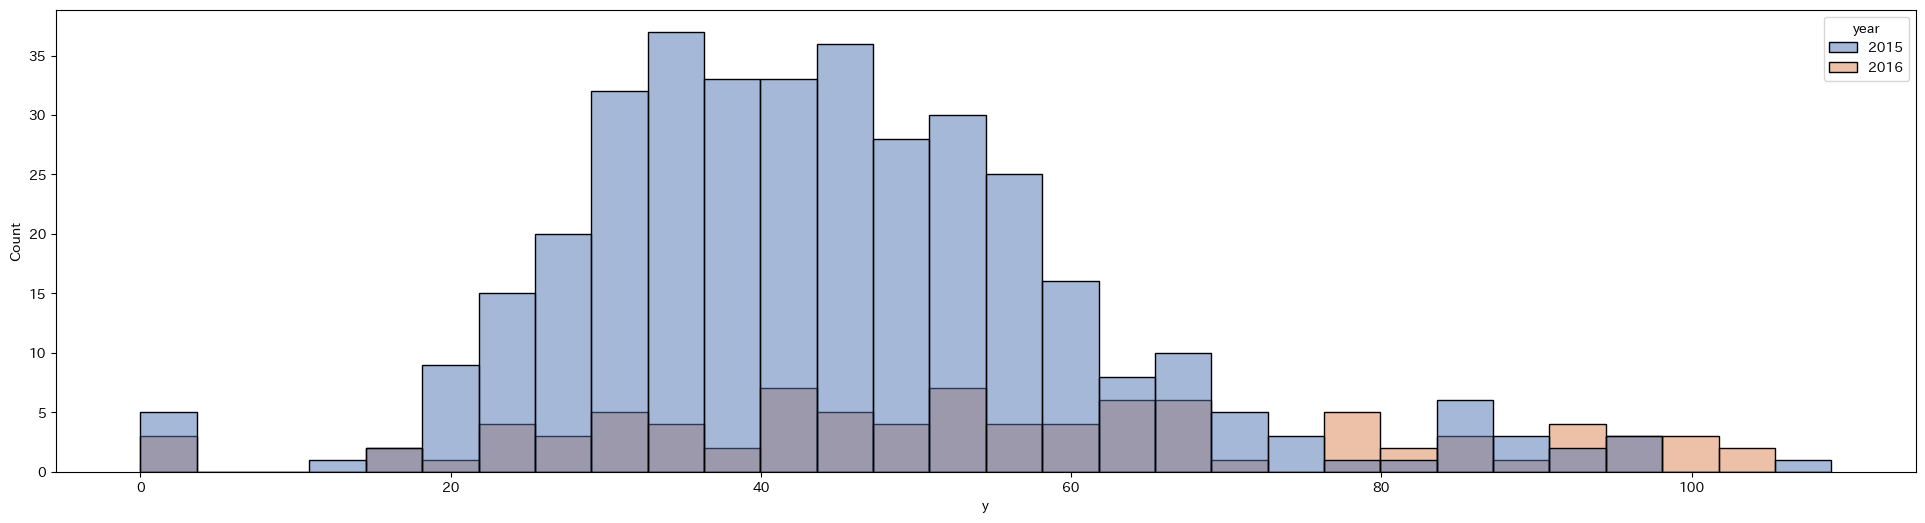

datetime                  0
y                         0
client                    0
close                     0
price_am                  0
price_pm                  0
year                      0
month                     0
day                       0
y_lag_364                 0
y_lag_365                 0
y_lag_366                 0
y_lag_7                   0
y_lag_14                  0
weekday                   0
is_weekend                0
is_holiday                0
day_type_int              0
dayofyear                 0
weekofyear                0
dayofyear_sin             0
dayofyear_cos             0
is_month_start            0
is_month_end              0
month_day                 0
is_new_year               0
is_year_end               0
is_obon                   0
is_long_holiday_season    0
dtype: int64


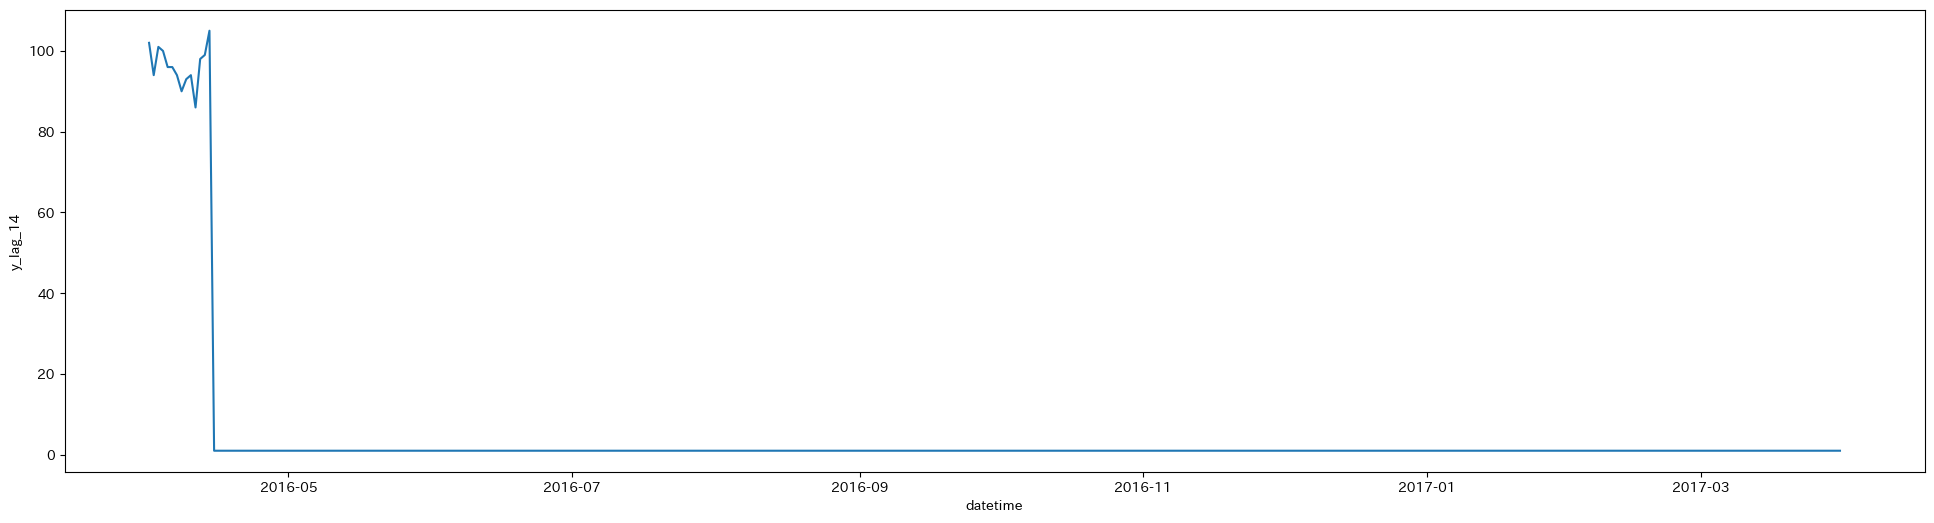

In [ ]:
#１
import numpy as np
import pandas as pd
import os
import matplotlib as plt
import seaborn as sns
import sweetviz as sv
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
import pandas_datareader.data as web #経済データや金融データをウェブから取得するためのライブラリ

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
train = pd.read_csv("./train.csv")
test  = pd.read_csv("./test.csv")

print(train.describe())

#object型の特徴量datetimeをdatetime型に変換
train["datetime"] = pd.to_datetime(train["datetime"])
test["datetime"] = pd.to_datetime(test["datetime"])

train.isna().sum()
"""
my_report = sv.compare([train, "Train"], [test, "Test"], "y")
 
# 直接ブラウザに表示
my_report.show_html("sweetviz_report_2col.html")
"""

#ラグ特徴量を生成する際に、テストデータのラグ特徴量は学習データの値を参照するので、学習データとテストデータを結合させる必要がある。2010-07-01～2016-03-31（学習データ）と2016-04-01～2017-03-31（テストデータ）を上下で結合させる。
test["y"] = 1

# 結合（上下に）
merged_train_test = pd.concat([train, test], axis=0).sort_values("datetime").reset_index(drop=True) #縦方向に、日付けを時系列順に(sort_values("datetime"))、インデックスを振りなおす(reset_index(drop=True))

import jpholiday

# datetime型から年・月・日へ分解して特徴量にする
merged_train_test["year"] = merged_train_test["datetime"].dt.year
merged_train_test["month"] = merged_train_test["datetime"].dt.month
merged_train_test["day"] = merged_train_test["datetime"].dt.day

"""
#ラグ（横軸）= 約365日前後で自己相関が上昇している → これは 1年周期の季節性が存在する強い証拠。それ以降も 730日前後（2年） にやや相関が見られる。
fig , axes = plt.subplots(figsize=(18,6)) #オブジェクト指向のやり方。描画オブジェクトとサブプロットを生成。引数に数値を指定することで画面を複数生成できる。引数にfigsize=(12,6)のようにすることで横12インチ、縦6インチに大きくできる。
plot_acf(train["y"], lags=730, ax=axes)  
axes.set_title("ACF（自己相関）")

plt.show()
"""

# yに関するラグ特徴量
target_col = 'y'

# 年次周期ラグ（±1日補完含む）
merged_train_test['y_lag_364'] = merged_train_test[target_col].shift(364)
merged_train_test['y_lag_365'] = merged_train_test[target_col].shift(365)
merged_train_test['y_lag_366'] = merged_train_test[target_col].shift(366)

# 短期・週次周期ラグ
merged_train_test['y_lag_7'] = merged_train_test[target_col].shift(7)
merged_train_test['y_lag_14'] = merged_train_test[target_col].shift(14)



"""
#price_am、price_pmにおいて、移動平均を加えてみる。この特徴量（-1も含めた-1～5までの値での移動平均）を追加で検証データに対するスコアは 5.58849735979813 となった。しかし、price_am、price_pmの -1 をNaN値とすることで、それぞれの平均値に -1の情報を加えない（-1 を平均値として加えると、意味のない価格になってしまう）移動平均とすることで
#検証データに対するスコアは 5.44 と改善した。追加前は検証データに対するスコアは 5.644228729661407だった。事前に -1 を NaN に変換（平均計算に含めないため）※負の平均値があった場合、意味のある価格ではなくなるため。
price_am_clean = merged_train_test["price_am"].replace(-1, np.nan)
price_pm_clean = merged_train_test["price_pm"].replace(-1, np.nan)
# 移動平均を計算
# 7日移動平均
merged_train_test["price_am_ma7"] = price_am_clean.rolling(window=7, min_periods=4).mean()
merged_train_test["price_pm_ma7"] = price_pm_clean.rolling(window=7, min_periods=4).mean()
# 14日移動平均
merged_train_test["price_am_ma14"] = price_am_clean.rolling(window=14, min_periods=7).mean()
merged_train_test["price_pm_ma14"] = price_pm_clean.rolling(window=14, min_periods=7).mean()
# 30日移動平均
merged_train_test["price_am_ma30"] = price_am_clean.rolling(window=30, min_periods=15).mean()
merged_train_test["price_pm_ma30"] = price_pm_clean.rolling(window=30, min_periods=15).mean()
#１年の移動平均
merged_train_test["price_am_ma365"] = price_am_clean.rolling(window=365, min_periods=180).mean()
merged_train_test["price_pm_ma365"] = price_pm_clean.rolling(window=365, min_periods=180).mean()
"""

#検証データではスコアが0.02上がったものの、コンペのスコアが悪くなった（スコア11以上)になったので、特徴量に加えない。
"""
#clientの値ごとにyの平均値で補完するターゲットエンコーディングの特徴量を追加。平均値は、clientの 0 , 1 の個数が違う（0の個数が1500個以上、1の個数が200程）ので、母数が大きいと当然平均値が小さくなるので、重みをつけた加重平均のターゲットエンコーディングとしている。検証データのスコアが0.02改善した。
# 全体平均
global_mean = train["y"].mean()
# client ごとの平均と件数
agg = train.groupby("client")["y"].agg(["mean", "count"])
# 加重平均：信頼度に応じて全体平均に近づける（ベイズ推定的）
agg["client_weighted_y"] = (agg["mean"] * agg["count"] + global_mean * 10) / (agg["count"] + 10)
# マッピング
train["client_y_encoded"] = train["client"].map(agg["client_weighted_y"])
test["client_y_encoded"] = test["client"].map(agg["client_weighted_y"])
# train の client_y_encoded のユニーク値ごとの本数を見る
train["client_y_encoded"].value_counts().sort_index().plot(kind="bar")
plt.title("client_y_encoded (train) distribution")
plt.xlabel("client_y_encoded value")
plt.ylabel("Frequency")
plt.show()
"""

"""
#コンペのスコアがさがったので、GDPの特徴量も却下。
#国内GDPを特徴量に追加（景気が良ければ引っ越し件数も増えるのでは？という着眼点から。）
# 必要な期間を定義（あなたの merged_train_test に合わせて）
# 開始・終了日を取得
start_date = merged_train_test["datetime"].min()
end_date = merged_train_test["datetime"].max()

# GDPの未来値補完のため、90日（約1四半期）多めに取得
extended_end_date = end_date + pd.Timedelta(days=90)

# 日本の実質GDP支出ベース（四半期）
gdp_quarterly = web.DataReader('JPNRGDPEXP', 'fred', start_date, extended_end_date)

# 四半期データを日次に変換し、線形補完＋前後補完
gdp_daily = gdp_quarterly.resample("D").interpolate(method="time").ffill().bfill()

# カラム名をわかりやすく変更
gdp_daily.rename(columns={"JPNRGDPEXP": "gdp_japan"}, inplace=True)

# datetimeをインデックスにして join
merged_train_test = merged_train_test.set_index("datetime")
merged_train_test = merged_train_test.join(gdp_daily)

# datetime をカラムに戻す
merged_train_test = merged_train_test.reset_index()
"""



#上のtrain['y_lag_366'] = train[target_col].shift(366)により、366日前のデータが存在しない場合は、その行は全てNaNになるので、そのNaNの行を削除する。ついでに、最初の行から連続して欠損値があるprice_am、price_pmを削除できるので、一石二鳥。
# y_lag_366 が NaN の行を削除
merged_train_test = merged_train_test.dropna(subset=['y_lag_366'])


#price_am、price_pmに１年の周期性があることから、これらのラグ特徴量も作成が望ましいが、先頭から365日分のデータのラグはNaNになってしまうので、とりあえずこの特徴量はあきらめる。
"""
for col in ['price_am', 'price_pm']:
    merged_train_test[f'{col}_lag_365'] = merged_train_test[col].shift(365)
"""

#欠損値の補完
#ラグが366の特徴量により、一番最初のデータ（2010-07-01）から365日後までのデータがNaNになったことから、それらを削除した。これにより、一番最初から欠損値が連続で続いていた欠損値を全て削除できた。残りの欠損値は休業日かつprice_am、price_pmともに-1である２３件と営業日かつprice_pmが-1の合計２４件。
#train[(train["price_am"] ==-1) &(train["price_pm"] == -1)]
#price_amが-1なのは全部で23件
#train[(train["price_am"] ==-1)]
merged_train_test.loc[459, "price_pm"] = 1 #営業日かつ欠損値があった箇所の欠損値補完。値は1で補完したが、平日（土日祝日ではなく）であり繁忙期でもなかったので、該当箇所の１週間近辺の値を参考に１で補完することにした。


# 曜日（0=月曜, 6=日曜）
merged_train_test['weekday'] = merged_train_test['datetime'].dt.dayofweek


# 土日フラグ(土日なら1を、平日なら0を)
merged_train_test['is_weekend'] = merged_train_test['weekday'].isin([5, 6]).astype(int)


# 日本の祝日（jpholidayで判定）※ True/False → 1/0 に変換
merged_train_test['is_holiday'] = merged_train_test['datetime'].apply(jpholiday.is_holiday).astype(int)


# 3分類の曜日タイプ（祝日 > 土日 > 平日）
merged_train_test['day_type'] = merged_train_test.apply(
    lambda row: 'Holiday' if row['is_holiday']
    else 'Weekend' if row['is_weekend']
    else 'Weekday',
    axis=1
)


# 数値カテゴリへ変換（祝日かつ土日は3、祝日は2、土日は1、平日は0）
merged_train_test['day_type_int'] = merged_train_test.apply(
    lambda row: 3 if row['is_holiday'] == 1 and row['is_weekend'] == 1 else
                2 if row['is_holiday'] == 1 else
                1 if row['is_weekend'] == 1 else
                0,
    axis=1
)



# datetime列を前提にカレンダー特徴量を作成
#月毎の傾向を捉える為（３月、４月は引っ越しが多いなど）
merged_train_test['month'] = merged_train_test['datetime'].dt.month
#月末、月初という月の頭とお尻を滑らかに、連続性のある値として把握するため。年度末（3月末〜4月初）は引っ越し需要が急増、夏（7月〜8月）はゆるやかな変化、年末年始に需要が変動するなど「飛び飛びのカテゴリ（month）」ではなく、滑らかな変動を把握するため。
merged_train_test['dayofyear'] = merged_train_test['datetime'].dt.dayofyear
merged_train_test['weekofyear'] = merged_train_test['datetime'].dt.isocalendar().week.astype(int)  
#dayofyear を連続値として使うだけでなく、連続性のある特徴量をさらに周期性を反映させた特徴量
merged_train_test['dayofyear_sin'] = np.sin(2 * np.pi * merged_train_test['dayofyear'] / 365)
merged_train_test['dayofyear_cos'] = np.cos(2 * np.pi * merged_train_test['dayofyear'] / 365)

#月末、月初という月の区切りを区別（認識）させるための特徴量を加える。
merged_train_test['is_month_start'] = merged_train_test['datetime'].dt.is_month_start.astype(int)
merged_train_test['is_month_end'] = merged_train_test['datetime'].dt.is_month_end.astype(int)
merged_train_test['month_day'] = merged_train_test['datetime'].dt.day

#移動平均と・移動中央値を特徴量としてみる。
#merged_train_test["y_ma_7"] = merged_train_test["y"].rolling(window=7).mean()
#merged_train_test["y_median_7"] = merged_train_test["y"].rolling(window=7).median()





#yは年月とともに、だだ

"""
#3月、４月が圧倒的に引っ越し件数が多いことから、年月毎の引っ越し件数の平均値（各年月と引っ越し件数のターゲットエンコーディング）を特徴量に加えてみる。あくまで学習データ(train)のyに対するターゲットエンコーディングしか行えないので、trainから平均値を割り出し、テストデータにも反映させる。
# 年・月を組み合わせた列を作成
merged_train_test["year_month"] = merged_train_test["datetime"].dt.to_period("M")

# 年月ごとの平均 y（学習データで計算）
year_month_avg_y = train.groupby(train["datetime"].dt.to_period("M"))["y"].mean()

# 学習・テスト両方にマップ
merged_train_test["year_month_y_target"] = merged_train_test["year_month"].map(year_month_avg_y)

"""


"""
fig , axes = plt.subplots(1 , 2 , figsize=(18,6)) #オブジェクト指向のやり方。描画オブジェクトとサブプロットを生成。引数に数値を指定することで画面を複数生成できる。引数にfigsize=(12,6)のようにすることで横12インチ、縦6インチに大きくできる。


#コレログラムとして見た場合、365日近辺で周期性があることが分かり、１年の周期性（季節変動）があると言える。※ラグが365日ジャストから若干ずれているが、まず時系列データでは完全な周期性はまず存在しない！気象・祝日・経済活動の様々なずれ等によって多少の「ズレ」が発生するため。
#したがって、365±数日の範囲で強い自己相関が現れるなら、周期性は存在しているとみなせる。
# 自己相関（ACF）
plot_acf(merged_train_test["price_am"], lags=1095, ax=axes[0])  # 適宜lags調整
axes[0].set_title("price_am_ACF（自己相関）")

# 偏自己相関（PACF）
plot_acf(merged_train_test["price_pm"], lags=1095, ax=axes[1])  # yule-walker（安定版）
axes[1].set_title("price_pm_ACF（自己相関）")


axes[0].legend()
axes[1].legend()
plt.show()
plt.close()  # メモリ解放
"""





train_price_client = train.groupby("client")["price_am"].mean()

train_price_client.plot(kind="bar" , xlabel= "train_client" , ylabel= "train_price_am")

"""
fig , axes = plt.subplots(1, 2, figsize=(24, 6), gridspec_kw={'width_ratios': [3, 1]})

g_time_client = sns.lineplot(data = merged_train_test , x = "datetime" , y = "y" , hue = "client" ,palette = "deep" ,  ax = axes[0])
g_hist_client = sns.histplot(data = merged_train_test , x = "y"  , hue = "client" , palette = "deep" , ax = axes[1])
plt.show()
plt.close()  # メモリ解放
"""


#merged_train_test[(merged_train_test["datetime"] >= "2016-03-30") & (merged_train_test["datetime"] <= "2016-04-10")]
merged_train_test[(merged_train_test["datetime"] >= "2016-03-25")&(merged_train_test["datetime"] <= "2016-04-10")]


merged_train_test
# -1 が含まれる列とその件数を確認
columns_with_minus_one = (merged_train_test == -1).any()
columns_with_minus_one = columns_with_minus_one[columns_with_minus_one].index.tolist()

# 各列の -1 の件数をカウント
minus_one_counts = merged_train_test[columns_with_minus_one].isin([-1]).sum()
print(minus_one_counts)

#休業日かつprice_am、price_pmが-1の個数が２８個ずつ（学習データ23個、テストデータ5個）となっている事が分かる。営業日はpriceは０～５の５段階であることを考慮すると、休業日は-1でもそれはそれで意味があると判断できる。（休業日は価格はオフという解釈）
merged_train_test[(merged_train_test["close"] ==1) & (merged_train_test["price_am"] == -1)].shape
merged_train_test[(merged_train_test["close"] ==1) & (merged_train_test["price_pm"] == -1)].shape


#学習データで、欠損値（-1)の個数は２５個しかないが、それぞれの特徴をみると正月３が日、大みそか、お盆の時期に休業日となっている傾向があり、その日に-1となっていることが分かる。
# 律上の祝日とは限らないが、**実務的に休業となる「準休日」**。以下のような特徴量を追加することで、LightGBMなどのモデルが「営業停止による price_am の -1」を適切に学習。ただし欠損値（-1）が２５個しかないので、どこまで影響を与えるかは分からない。
# 正月（1/1〜1/3）
merged_train_test['is_new_year'] = ((merged_train_test['datetime'].dt.month == 1) & (merged_train_test['datetime'].dt.day <= 3)).astype(int)

# 大晦日（12/31）
merged_train_test['is_year_end'] = ((merged_train_test['datetime'].dt.month == 12) & (merged_train_test['datetime'].dt.day == 31)).astype(int)

# お盆（8/11〜8/13程度）
merged_train_test['is_obon'] = ((merged_train_test['datetime'].dt.month == 8) & (merged_train_test['datetime'].dt.day.between(11, 13))).astype(int)

# 総合特徴量（長期休暇シーズン）
merged_train_test['is_long_holiday_season'] = (merged_train_test['is_new_year'] | merged_train_test['is_year_end'] | merged_train_test['is_obon']).astype(int)


#データ値がオブジェクト型の"day_type"を削除
merged_train_test = merged_train_test.drop(["day_type"] , axis =1)


#結合したデータフレームを学習データとテストデータに分割。
train = merged_train_test[merged_train_test['datetime'] <= '2016-03-31'].copy()
test  = merged_train_test[merged_train_test['datetime'] >  '2016-03-31'].copy()

#テストデータからカラム y を削除
test = test.drop(["y"] , axis=1)


"""
test[(test["close"] == 1) & (test["price_am"] == -1)]

client_price_am = train["price_am"].replace(-1 , np.nan).groupby(train["client"]).mean()

client_price_am.plot(kind="bar", figsize=(12, 5), title="Client-wise average price_am (excluding -1)")
plt.xlabel("Client")
plt.ylabel("Average price_am")
plt.tight_layout()
plt.show()
plt.close()  # メモリ解放
"""

#client毎のyの分布も確認したい
#==================================================#





#==================================================#

#学習データの各年月日におけるyの推移とyの分布
fig , axes = plt.subplots(1 , 2 , figsize=(24, 6))
g_time = sns.lineplot(data = train , x= "datetime" ,y = "y" , ax = axes[0])
g_hist = sns.histplot(data = train , x = "y" , ax = axes[1])
plt.setp(g_time , ylim = (0,120))
plt.show()
plt.close()  # メモリ解放

#各年毎のyの推移を色付け、各年毎のyの分布を確認。年月とともに、分布が右の方向にシフトしている。⇒　未来のyの分布と過去のyの分布が同じではないということ！つまり機械学習モデルの前提である「学習データとテストデータの分布が同じ」でないと精度が落ちる！（←超重要）
fig, axes = plt.subplots(1, 2, figsize=(24, 6), gridspec_kw={'width_ratios': [3, 1]})

g_time_year = sns.lineplot(data = train , x = "datetime" , y = "y" , hue = "year" ,palette = "deep" ,  ax = axes[0])
g_hist_year = sns.histplot(data = train , x = "y" ,  kde = True , hue = "year" , palette = "deep" , ax = axes[1])

plt.setp(g_time_year.get_xticklabels(), rotation = 90)
plt.setp(g_time_year , ylim=(0,120))

fig , axes = plt.subplots(1 , 1 , figsize=(24, 6))

sns.histplot(data=train[train["year"].isin([2015, 2016])],x="y", hue="year", bins=30, palette="deep", multiple="layer")
plt.show()
plt.close()  # メモリ解放


print(train.isna().sum())
test.isna().sum()


#学習データにおいて、休業日（外れ値）25個の行を全て削除し、営業日のみを予測させるモデルにする。テストデータでは休業日の 目的変数 yを0にする。←これは凡化性能に影響はしない。休業日は「予測しなくても必ず y=0」であることが事前にわかっており、モデルで予測する必要がない。
train = train[train["close"] != 1]
test[test["close"] == 1]

train["datetime"].dtypes


#テストデータのラグ特徴量の値を確認。ラグが365日だと一年ずれた一年前の数値になっているが、14日だと特徴量としては使えない
fig , axes = plt.subplots(1,1 , figsize=(24,6))

g_lag = sns.lineplot(data = test , x = "datetime" , y="y_lag_14" )

plt.show()
plt.close()

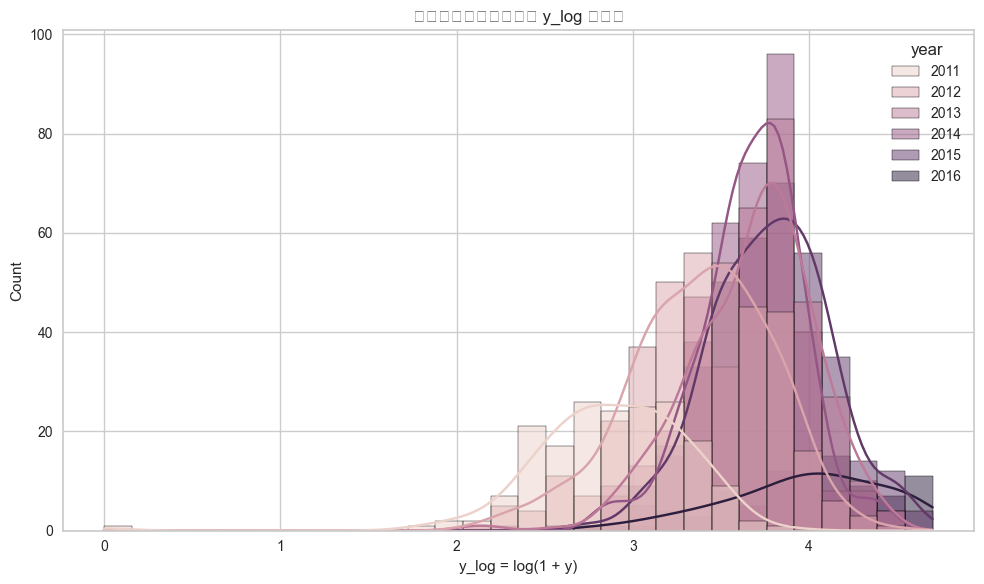

19:22:48 - cmdstanpy - INFO - Chain [1] start processing
19:22:49 - cmdstanpy - INFO - Chain [1] done processing


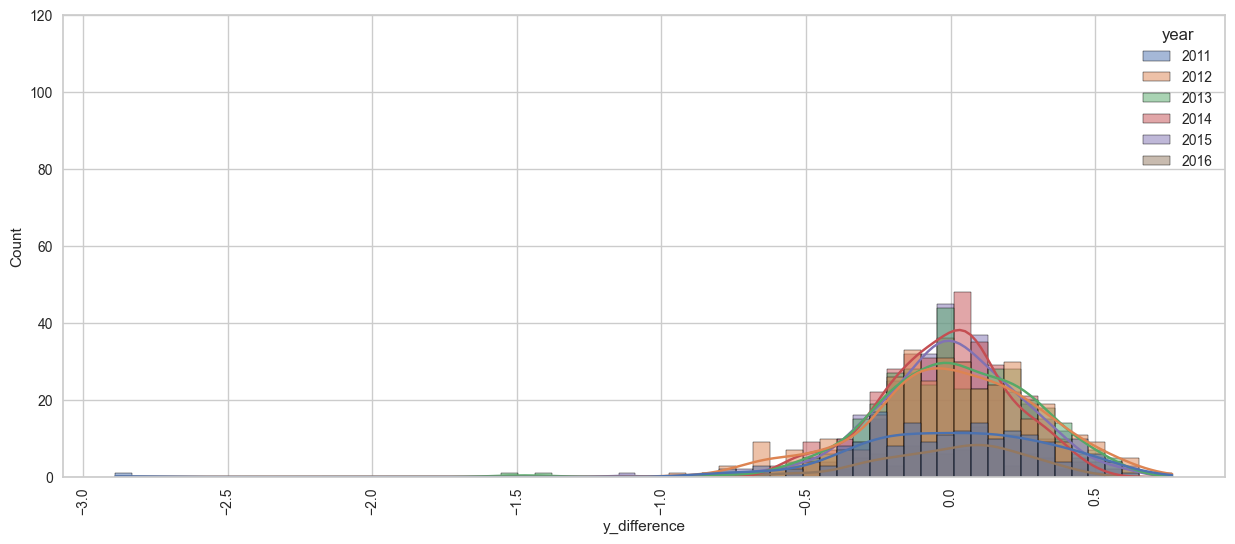

,datetime,client,close,price_am,price_pm,year,month,day,y_lag_364,y_lag_365,y_lag_366,y_lag_7,y_lag_14,weekday,is_weekend,is_holiday,day_type_int,dayofyear,weekofyear,dayofyear_sin,dayofyear_cos,is_month_start,is_month_end,month_day,is_new_year,is_year_end,is_obon,is_long_holiday_season,yhat
0,2016-04-01,1,0,3,2,2016,4,1,75.0,60.0,61.0,90.0,102.0,4,0,0,0,92,13,0.999917,-0.012910,1,0,1,0,0,0,0,4.355059
1,2016-04-02,0,0,5,5,2016,4,2,86.0,75.0,60.0,93.0,94.0,5,1,0,1,93,13,0.999546,-0.030120,0,0,2,0,0,0,0,4.540207
2,2016-04-03,1,0,2,2,2016,4,3,69.0,86.0,75.0,94.0,101.0,6,1,0,1,94,13,0.998880,-0.047321,0,0,3,0,0,0,0,4.412075
3,2016-04-04,1,0,1,1,2016,4,4,61.0,69.0,86.0,86.0,100.0,0,0,0,0,95,14,0.997917,-0.064508,0,0,4,0,0,0,0,4.265129
4,2016-04-05,0,0,1,1,2016,4,5,54.0,61.0,69.0,98.0,96.0,1,0,0,0,96,14,0.996659,-0.081676,0,0,5,0,0,0,0,4.118483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2017-03-27,0,0,5,4,2017,3,27,86.0,94.0,93.0,1.0,1.0,0,0,0,0,86,13,0.995919,0.090252,0,0,27,0,0,0,0,4.520103
361,2017-03-28,0,0,4,4,2017,3,28,98.0,86.0,94.0,1.0,1.0,1,0,0,0,87,13,0.997325,0.073095,0,0,28,0,0,0,0,4.387272
362,2017-03-29,0,0,3,3,2017,3,29,99.0,98.0,86.0,1.0,1.0,2,0,0,0,88,13,0.998435,0.055917,0,0,29,0,0,0,0,4.349751
363,2017-03-30,0,0,4,3,2017,3,30,105.0,99.0,98.0,1.0,1.0,3,0,0,0,89,13,0.999250,0.038722,0,0,30,0,0,0,0,4.356439


In [9]:
#２
from prophet import Prophet
#目的：学習データの目的変数とテストデータの目的変数の分布を同じ分布にさせる（非線形変換）


# 各年の y の分布が右に裾野が広がっているので、バラツキが大きい時系列を扱いやすくするために、自然対数変換で裾野を狭める。
train["y_log"] = np.log1p(train["y"])  # log(1 + y) ← 自然対数

# ヒストグラム描画
plt.figure(figsize=(10, 6))
sns.histplot(data = train ,  x = "y_log" , bins=30, kde=True,  hue = "year" ,color='skyblue', edgecolor='black') #引数 kde = True にすることで、ヒストグラムに正規分布っぽいグラフを描画できる。

plt.title("対数変換後の目的変数 y_log の分布")
plt.xlabel("y_log = log(1 + y)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

#右に広がる裾野を狭めたとはいえ、下のヒストグラムのように各年の y の分布が異なっているので、このままモデルに学習させるとその分布の特徴で予測してしまい、学習データとテストデータの目的変数の分布が異なった状態で予測するため、精度が落ちてしまう。
#なので、各年毎の分布の差分を考慮（その差分を特徴量に加える）する必要がある。単なる差分では意味がない。「各年毎の y の分布が異なっているので、機械学習モデルは学習データをもとにした予測値で発生するズレが原因」なので、モデルが予測する値との差分を考慮する必要がある。
#学習させるモデルは時系列データにおいて、将来予測に適したprophetモデルを使う。

prophet_model = Prophet()

#prophetモデルは学習データでは特徴量にdatetime型の dsという特徴量と目的変数 y を含む必要があるので、その仕様に変更。テストデータは ds (datetime型)さえあればok! 
train_x = train[["y_log" , "datetime"]].rename(columns = {"y_log" : "y" , "datetime" : "ds"}) 
test_x = test[["datetime"]].rename(columns = {"datetime" : "ds"})
prophet_model.fit(train_x)

#train["y"] の値は対数変換されているので、このモデルが予測する値は対数変換された y の値であることに注意！つまり train_y_prophet , test_y_prophet は対数変換された値である。
train_y_prophet = prophet_model.predict(train_x)
test_y_prophet = prophet_model.predict(test_x)

#　train , test_y_prophet , test に対して行を削除、その値を保持させる。
train.reset_index(drop = True , inplace = True)
test_y_prophet.reset_index(drop = True , inplace = True)
test.reset_index(drop = True, inplace = True)

train_x = pd.concat([train , train_y_prophet["yhat"]] , axis =1).rename({"y" : "y_log" , "ds" : "datetime"})
test_x = pd.concat([test , test_y_prophet["yhat"]] , axis =1).rename({"ds" : "datetime"})


# y（対数変換された目的変数）とモデルの予測値（対数変換された予測値）の差分を特徴量にすることで、各年ごとの y の分布を揃える。（対数差分）。学習データに対してこの差分をとることで、各年の分布の異なりを統一⇒つまり、テストデータにも対応する特徴量であり、
#テストデータに "y_difference" の特徴量を追加しなくても問題ない（学習データだけに特徴量 "y_difference" を追加)
train_x["y_difference"] = train["y_log"] - train_x["yhat"]


fig, axes = plt.subplots(1, 1, figsize=(15, 6))

g_hist_year = sns.histplot(data = train_x , x = "y_difference" ,  kde = True , hue = "year" , palette = "deep" )

plt.setp(g_hist_year.get_xticklabels(), rotation = 90)
plt.setp(g_hist_year , ylim=(0,120))
plt.show()

train_x
test_x

In [ ]:
#３
from lightgbm import LGBMRegressor , early_stopping , log_evaluation
from sklearn.model_selection import TimeSeriesSplit , GridSearchCV
from sklearn.metrics import make_scorer , mean_absolute_error
from sklearn.model_selection import train_test_split
import optuna.integration.lightgbm as lgb_op
import lightgbm as lgb


#学習データを目的変数と特徴量に分ける。datetime型はLightGBMや多くのMLモデルで直接処理できないので、この特徴量も省く。また学習データは営業日のみのデータで学習させるので、テストデータを与えたときに予測するのは営業日モデルの値になるので、予測した後は
#テストデータの休業日はyを0にすること（作為的にやって問題はない。そういうルールのもとで作ったモデルだから⇒新しい未知のデータでも休業日はyを0にするという統一を図ることで凡化対応できる）
train_y = train_x["y_difference"]
train_x = train_x.drop(["y" , "y_log" , "datetime" , "y_difference"] , axis = 1)
#テストデータもdatetime型を削除
test_x = test_x.drop(["datetime"] , axis = 1)

"""
#時系列交差検証によるlightGBMモデル

#ただの交差検証ではなく時系列データのため、時系列交差検証　TimeSeriesSplit　による分割を行う。TimeSeriesSplitの特性は前方累積であり、データを累積していくので、グリッドサーチを行った場合、各Foldは最初から２０％までのデータ、最初から４０％までのデータ、、、という累積データの各Foldで最も
#スコアがよかったときのハイパラを採用する。つまりベストモデルのこと。そして、このベストモデルはその最適なパラメータで最後のFold（最初から80%までのデータ）を学習したモデルとなっている。
tscv = TimeSeriesSplit(n_splits = 5)

param_grid = {
    "n_estimators": [100 , 200 , 300],
    "max_depth": [4 , 5 , 6],
    "learning_rate": [0.01, 0.05 , 0.07],
    "num_leaves": [15, 17 , 20],
}

lgb_model = LGBMRegressor(objective = "regression" , random_state = 42)

#make_scorerの関数で引数にMAEを計算してくれているmean_absolute_errorを渡す。MAEは値が小さければ小さいほど良いので、greater_is_better = Falseで、値が小さいほど良いと設定している。
mae_score = make_scorer(mean_absolute_error , greater_is_better = False)

#グリッドサーチでMAEが一番小さくなるように時系列データの交差検証を行い、またハイパラメーターを探す。
lgb_gcv = GridSearchCV(estimator = lgb_model , param_grid = param_grid , cv = tscv , scoring = mae_score , return_train_score = True  , verbose = 1 , n_jobs = -1) #verbose = 1 でグリッドサーチの進捗状況を表示させる。n_jobs = -1 でPCの全CPUコアを使って並列計算させる。

#アーリーストッピング（N回連続で値が改善しない（スコアが良くならない）場合、そこで処理を打ち切る）を設定。アーリーストッピングにはcallback関数を定義。
callbacks = [early_stopping(stopping_rounds = 10 , verbose = False)  , log_evaluation(10)] #log_evaluation(10)により、１０イテレーション毎にログを表示させる。

#アーリーストッピングはGridsearchCV が内部で fit() を 何回も実行してCVするので、各foldごとに eval_set を渡すのが難しい。つまりGridsearCVとcallbacksを併用するとエラーとなる。callbacks=early_stopping()は 手動で交差検証する場合に向いている。今回はアーリーストッピングは使用しないことにする。
#lgb_gcv.fit(train_x , train_y , callbacks = callbacks)

lgb_gcv.fit(train_x , train_y)

#今回評価関数はMAEであり、これを最小にするモデルの構築を行っている。
cv_results = pd.DataFrame(lgb_gcv.cv_results_)
print("検証データに対する平均スコア（MAEの負値）:")
print(cv_results.loc[lgb_gcv.best_index_, 'mean_test_score'])

#scikit-learnライブラリの性質上、評価関数を最大にするという前提のため、make_scorer()関数でgreater_is_better = Falseにすると、
# GridsearCV()を使うとき、内部的に -1 x MAE という形で扱われ、「-MAEが最大になる = MAEが最小になる」**という変換が行われている。従ってMAEのスコアを確認するには-1を掛ける必要がある）
mean_mae = -1 * cv_results.loc[lgb_gcv.best_index_, 'mean_test_score']
print(f"ベストモデルの平均MAE（検証データ）: {mean_mae:.4f}")

print("Best Hyperparameters:", lgb_gcv.best_params_)



# ベストモデルの取得
best_model = lgb_gcv.best_estimator_

# グリッドサーチで得られたベストなハイパーパラメータで全体の学習データを再学習。※lgb_gcv.best_estimator_に全体のデータを学習させればいいのでは？と思うが、best_estimator_ は GridSearchCV の内部処理で
# 既に .fit() されているモデルインスタンス。そのため、再学習しても一部の属性や内部状態が正しく更新されない可能性がある（特に .best_iteration_ や evals_result_ など）なので、新たなモデルで全体を学習させる必要がある
final_model = LGBMRegressor(
    objective="regression",
    random_state=42,
    **lgb_gcv.best_params_
)

# データ全体のtrain_x, train_yで再学習
final_model.fit(train_x, train_y)



# ベストモデル（最適なハイパラ＆KFoldの最後のfoldのデータ(5分割の場合、学習データは80%）を学習したモデルであり、全体を学習しているわけではないので、最後にさっき求めた最適なハイパラでデータ全体を学習させる必要がある）の特徴量重要度を
# 取得（重要度の種類: 'split' or 'gain'）
importances = pd.Series(
    best_model.feature_importances_,
    index=train_x.columns
).sort_values(ascending=False)

# 上位30特徴量を可視化
plt.figure(figsize=(12, 6))
importances.head(30).plot(kind='bar')
plt.title("Feature Importance (Top 30)")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


importances = pd.Series(
    final_model.feature_importances_,
    index=train_x.columns
).sort_values(ascending=False)

# 上位30特徴量を可視化
plt.figure(figsize=(12, 6))
importances.head(30).plot(kind='bar')
plt.title("Feature Importance (Top 30)")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

"""
"""
#時系列交差検証によるlightGBMモデルよりも train_test_split()でのlightGBMモデルの方が精度が上がったという事例がコンペサイトで見かけたので、試してみる。⇒train_test_split() + optunaでのlightGBMモデルで10.6から10.3にスコアが上がった！
x_train , x_val , y_train , y_val = train_test_split(train_x , train_y , test_size = 0.2 , shuffle = True , random_state = 42)

train_lgb = lgb.Dataset(x_train , y_train)
val_lgb = lgb.Dataset(x_val , y_val)

params = {"objective" : "regression" , "metric" : "mae" , "verbose" : -1}

#tuner.run()でエラー（回帰なのに分類と認識してしまうエラー）がでたので、stratified=False を指定することで回帰に変更できた。
tuner = lgb_op.LightGBMTunerCV(params  , train_lgb  , num_boost_round = 1000 , optuna_seed =  123 , show_progress_bar = True , stratified=False)

tuner.run()

print("best_score :" , {tuner.best_score})
print("best_params")
print(tuner.best_params)
"""

#上記のtrain_test_split()によるlightgbmモデルより、こっちのkfoldのシャッフルあり、分割数１０のモデル方がsignateスコアが0.6も上がった！！pycaretと同じデータの分割法（lightgbmモデルとpycaretモデルの分割法を統一させた。）
from sklearn.model_selection import KFold


# KFold（シャッフルあり、10分割）
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# データセット作成
train_lgb = lgb.Dataset(train_x, label=train_y)

# パラメータ設定
params = {
    "objective": "regression",
    "metric": "mae",
    "verbose": -1
}

# Optuna によるチューニング（KFold 指定）
tuner = lgb_op.LightGBMTunerCV(
    params=params,
    train_set=train_lgb,
    folds=kfold,
    num_boost_round=1000,
    optuna_seed=123,
    show_progress_bar=True
)

# チューニング実行
tuner.run()

# 結果表示
print("best_score:", tuner.best_score)
print("best_params:")
print(tuner.best_params)




[I 2025-06-18 19:22:53,813] A new study created in memory with name: no-name-17ecddeb-28b4-413e-a8e7-9fd21bf03c3f
min_child_samples, val_score: 0.153563: 100%|##########| 5/5 [00:22<00:00,  4.51s/it]

best_score: 0.15356288899573345
best_params:
{'objective': 'regression', 'metric': 'l1', 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 1.0167142172852008e-08, 'lambda_l2': 3.1920304724554293e-07, 'num_leaves': 6, 'feature_fraction': 0.4, 'bagging_fraction': 0.7611331612295218, 'bagging_freq': 5, 'min_child_samples': 25}


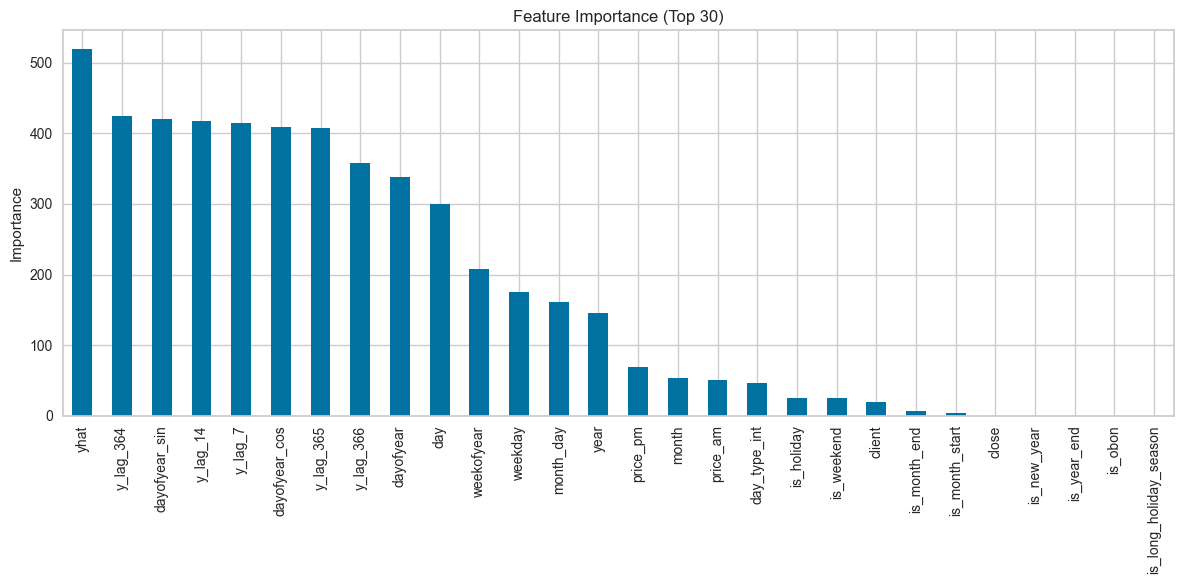

,client,close,price_am,price_pm,year,month,day,y_lag_364,y_lag_365,y_lag_366,y_lag_7,y_lag_14,weekday,is_weekend,is_holiday,day_type_int,dayofyear,weekofyear,dayofyear_sin,dayofyear_cos,is_month_start,is_month_end,month_day,is_new_year,is_year_end,is_obon,is_long_holiday_season,yhat
137,0,1,-1,-1,2016,8,16,29.0,39.0,22.0,1.0,1.0,1,0,0,0,229,33,-0.717677,-0.696376,0,0,16,0,0,0,0,3.639817
274,0,1,-1,-1,2016,12,31,0.0,0.0,0.0,1.0,1.0,5,1,0,1,366,52,0.017213,0.999852,0,1,31,0,1,0,1,3.938815
275,0,1,-1,-1,2017,1,1,0.0,0.0,0.0,1.0,1.0,6,1,1,3,1,52,0.017213,0.999852,1,0,1,1,0,0,1,3.815708
276,0,1,-1,-1,2017,1,2,24.0,0.0,0.0,1.0,1.0,0,0,1,2,2,1,0.034422,0.999407,0,0,2,1,0,0,1,3.676413
277,0,1,-1,-1,2017,1,3,17.0,24.0,0.0,1.0,1.0,1,0,0,0,3,1,0.051620,0.998667,0,0,3,1,0,0,1,3.540043


In [11]:
#４
#train_test_split()により、シャッフルした学習データ(80%)と検証データに対して、モデルはlightGBMモデルで、ハイパラはouptunaにより最適化した。この最適化したハイパラでデータ全体を学習させる。
full_data = lgb.Dataset(train_x , train_y)
light_final_model = lgb.train(tuner.best_params , full_data , num_boost_round = 1000)

#test_pred はy_differenceの予測値になるので、この値にyhatを加え（対数変換されているので逆変換）逆変換する。
test_pred = light_final_model.predict(test_x)


# Step 1: y_log を再構成
y_log_pred = test_pred + test_x["yhat"]

# Step 2: 逆対数変換で y を再構成
y_pred_lgbm = np.exp(y_log_pred)

#テストデータの休業日の y の値を0にする。休業日のインデックスを取得（close == 1 の行）
close_idx = test_x[test_x["close"] == 1].index

#該当行の予測値を 0.0 に上書き
y_pred_lgbm[close_idx] = 0.0



"""
# 提出ファイルのテンプレートを読み込み
submit_df = pd.read_csv("sample_submit.csv", header=None)

# 提出ファイルに予測値を反映
submit_df[1] = y_pred

# 提出ファイルとして保存
submit_df.to_csv("submit1.csv", index=False , header=False)
"""



#boosterモデル（lgb.train()API）で得られるモデルには特徴量重要度の属性（feature_importances_)がないので、 final_model.feature_importances_　という指定はできない。しかし、特徴量重要度のメソッド（feature_importances())があるので、それで指定してやる。
#Scikit-learnAPI（LGBMRegressor())の場合は属性feature_importances_が使える。
importances = pd.Series(
light_final_model.feature_importance(importance_type = "split") , #importtance_type "gain"の場合、その特徴量がもたらした損失関数の改善量の合計、importtance_type "split"の場合、その特徴量が使われた 回数を表す。
index=train_x.columns
).sort_values(ascending=False)


# 上位30特徴量を可視化
plt.figure(figsize=(12, 6))
importances.head(30).plot(kind='bar')
plt.title("Feature Importance (Top 30)")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()
"""
importances = pd.Series(
    final_model.feature_importances_,
    index=train_x.columns
).sort_values(ascending=False)

# 上位30特徴量を可視化
plt.figure(figsize=(12, 6))
importances.head(30).plot(kind='bar')
plt.title("Feature Importance (Top 30)")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()
"""


#時系列交差検証によるlightGBMモデルよりもtrain_test_split()の方が精度が上がったという事例がコンペサイトで見かけたので、試してみる。
"""
# 提出ファイルのテンプレートを読み込み
submit_df = pd.read_csv("sample_submit.csv", header=None)

# ベストモデルにおいて、全データで再学習させたfinal_modelで test_x を予測
test_pred = final_model.predict(test_x)

# 提出ファイルに予測値を反映
submit_df[1] = test_pred

# 提出ファイルとして保存
submit_df.to_csv("submit1.csv", index=False , header=False)

# 確認（必要なら）
print(submit_df.head())
submit_df
"""

test_x[test_x["close"] == 1]

In [26]:
print(train_x.shape)
test_x.shape

(1712, 28)


(365, 28)

In [ ]:
#５
# #Pycaretモデル
from pycaret.regression import *


pycaret_df = train_x.copy()
pycaret_df["y_difference"] = train_y.values

if "datetime" in pycaret_df.columns:
    pycaret_df = pycaret_df.drop(columns=["datetime"])

reg_setup = setup(
    data=pycaret_df,
    target="y_difference",
    session_id=42,
    train_size=0.8,
    imputation_type="simple",
    #fold_starategy ="KFold" ←デフォルトはランダムありのはkfold , 今回はtrain_test_split()でシャッフルありで分割しているのでそれに合わせてpycaretモデルも同じ分割方法で 
)

pycaret_best_model = compare_models(sort="MAE")
pycaret_final_model = finalize_model(pycaret_best_model)

# テストデータから y_difference を予測
test_pycaret = predict_model(pycaret_final_model, data=test_x)

# PyCaretの予測結果は "prediction_label" 列に格納されている。※予測されたy_differenceは対数変換されているので、y_differenceとyhatを足し合わせた結果を逆変換している。
y_pred_pycaret = np.exp(test_pycaret["prediction_label"].values + test_x["yhat"].values)

# 休業日のインデックスを取得（close == 1）
close_idx = test_x[test_x["close"] == 1].index

# 休業日の予測値を 0 に
y_pred_pycaret[close_idx] = 0.0


# compare_models() の結果一覧を取得
result_df = pull()

# 1行目が最良モデルの結果（MAEなど）
best_model_score = result_df.iloc[0]
print(best_model_score)




,Description,Value
0,Session id,42
1,Target,y_difference
2,Target type,Regression
3,Original data shape,"(1712, 29)"
4,Transformed data shape,"(1712, 29)"
5,Transformed train set shape,"(1369, 29)"
6,Transformed test set shape,"(343, 29)"
7,Numeric features,28
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.1510,0.0406,0.2004,0.4345,0.1338,2.5963,1.1700
gbr,Gradient Boosting Regressor,0.1529,0.0416,0.2027,0.4214,0.1343,3.1892,0.1020
rf,Random Forest Regressor,0.1542,0.0410,0.2016,0.4266,0.1354,2.8821,0.3000
et,Extra Trees Regressor,0.1567,0.0418,0.2038,0.4139,0.1354,3.4688,0.1960
lightgbm,Light Gradient Boosting Machine,0.1575,0.0434,0.2073,0.3936,0.1381,2.2288,0.1260
xgboost,Extreme Gradient Boosting,0.1626,0.0462,0.2138,0.3543,0.1394,2.6319,0.1310
ridge,Ridge Regression,0.1678,0.0480,0.2186,0.3252,0.1446,4.2281,0.0130
lr,Linear Regression,0.1680,0.0479,0.2183,0.3273,0.1445,4.4427,1.5680
br,Bayesian Ridge,0.1683,0.0484,0.2194,0.3199,0.1460,4.1610,0.0130
ada,AdaBoost Regressor,0.1691,0.0490,0.2207,0.3134,0.1386,3.8137,0.0570


Model       CatBoost Regressor
MAE                      0.151
MSE                     0.0406
RMSE                    0.2004
R2                      0.4345
RMSLE                   0.1338
MAPE                    2.5963
TT (Sec)                  1.17
Name: catboost, dtype: object


In [12]:
#６
# # 1. それぞれの予測結果を事前に準備しておく
# y_pred_lgbm: LightGBMによる予測値（すでに exp(yhat + y_difference) 済み）
# y_pred_pycaret: PyCaret（CatBoost）による予測値（すでに exp(yhat + y_difference) 済み）

# 2. モデルの検証スコア（MAEなど）を手動で入力する（小さい方に重みを大きく）
mae_lgbm = 0.15356288899573345  # LightGBMの検証スコア（仮値）
mae_pycaret = 0.151  # PyCaret（CatBoost）の検証スコア

# 3. スコアの逆数で重みを決定（良いモデルに大きな重みを）
w_lgbm = 1 / mae_lgbm
w_pycaret = 1 / mae_pycaret
w_sum = w_lgbm + w_pycaret

# 4. 重み付き平均でアンサンブル予測
y_pred_ensemble = (y_pred_lgbm * w_lgbm + y_pred_pycaret * w_pycaret) / w_sum

# 5. 休業日のインデックスに対して 0 に修正（これは必ず保持すること）
close_idx = test_x[test_x["close"] == 1].index
y_pred_ensemble[close_idx] = 0.0

# 6. 提出ファイルの作成
submit_df = pd.read_csv("sample_submit.csv", header=None)
submit_df[1] = y_pred_ensemble
submit_df.to_csv("submit_ensemble.csv", index=False, header=False)

print("アンサンブル予測完了：submit_ensemble.csv を作成しました。")


アンサンブル予測完了：submit_ensemble.csv を作成しました。


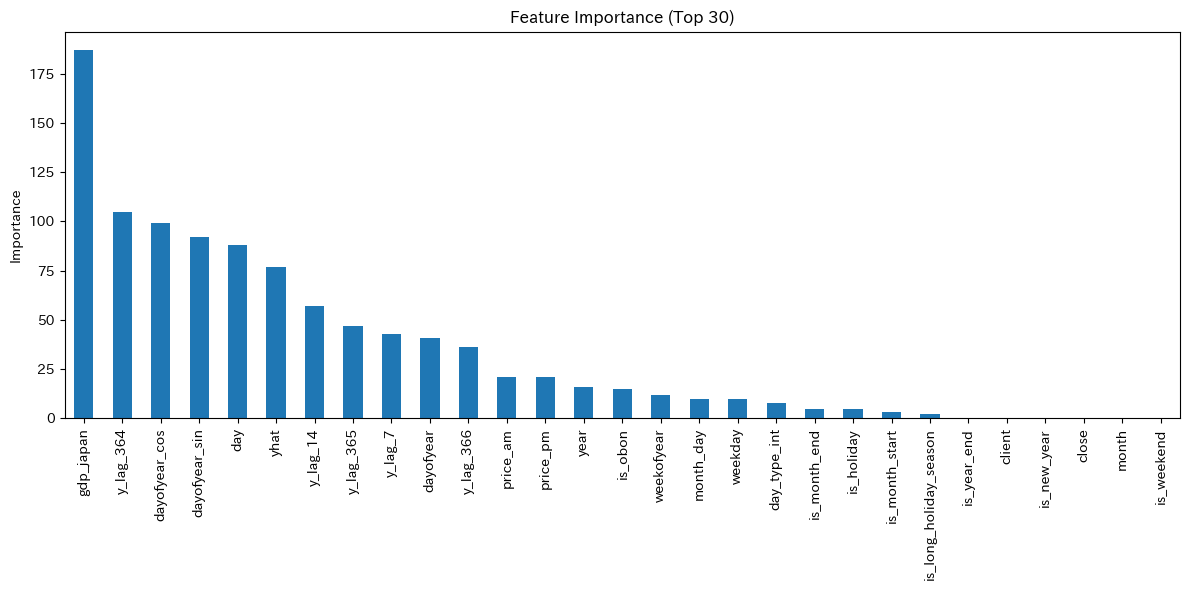

,client,close,price_am,price_pm,year,month,day,y_lag_364,y_lag_365,y_lag_366,y_lag_7,y_lag_14,gdp_japan,weekday,is_weekend,is_holiday,day_type_int,dayofyear,weekofyear,dayofyear_sin,dayofyear_cos,is_month_start,is_month_end,month_day,is_new_year,is_year_end,is_obon,is_long_holiday_season,yhat
137,0,1,-1,-1,2016,8,16,29.0,39.0,22.0,1.0,1.0,542529.600000,1,0,0,0,229,33,-0.717677,-0.696376,0,0,16,0,0,0,0,3.639817
274,0,1,-1,-1,2016,12,31,0.0,0.0,0.0,1.0,1.0,547129.923913,5,1,0,1,366,52,0.017213,0.999852,0,1,31,0,1,0,1,3.938815
275,0,1,-1,-1,2017,1,1,0.0,0.0,0.0,1.0,1.0,547176.600000,6,1,1,3,1,52,0.017213,0.999852,1,0,1,1,0,0,1,3.815708
276,0,1,-1,-1,2017,1,2,24.0,0.0,0.0,1.0,1.0,547199.825556,0,0,1,2,2,1,0.034422,0.999407,0,0,2,1,0,0,1,3.676413
277,0,1,-1,-1,2017,1,3,17.0,24.0,0.0,1.0,1.0,547223.051111,1,0,0,0,3,1,0.051620,0.998667,0,0,3,1,0,0,1,3.540043


In [ ]:
#train_test_split()により、シャッフルした学習データ(80%)と検証データに対して、モデルはlightGBMモデルで、ハイパラはouptunaにより最適化した。この最適化したハイパラでデータ全体を学習させる。
full_data = lgb.Dataset(train_x , train_y)
light_final_model = lgb.train(tuner.best_params , full_data , num_boost_round = 1000)

#test_pred はy_differenceの予測値になるので、この値にyhatを加え（対数変換されているので逆変換）逆変換する。
test_pred = light_final_model.predict(test_x)


# Step 1: y_log を再構成
y_log_pred = test_pred + test_x["yhat"]

# Step 2: 逆対数変換で y を再構成
y_pred = np.exp(y_log_pred)

#テストデータの休業日の y の値を0にする。休業日のインデックスを取得（close == 1 の行）
close_idx = test_x[test_x["close"] == 1].index

#該当行の予測値を 0.0 に上書き
y_pred[close_idx] = 0.0




# 提出ファイルのテンプレートを読み込み
submit_df = pd.read_csv("sample_submit.csv", header=None)

# 提出ファイルに予測値を反映
submit_df[1] = y_pred

# 提出ファイルとして保存
submit_df.to_csv("submit1.csv", index=False , header=False)




#boosterモデル（lgb.train()API）で得られるモデルには特徴量重要度の属性（feature_importances_)がないので、 final_model.feature_importances_　という指定はできない。しかし、特徴量重要度のメソッド（feature_importances())があるので、それで指定してやる。
#Scikit-learnAPI（LGBMRegressor())の場合は属性feature_importances_が使える。
importances = pd.Series(
light_final_model.feature_importance(importance_type = "split") , #importtance_type "gain"の場合、その特徴量がもたらした損失関数の改善量の合計、importtance_type "split"の場合、その特徴量が使われた 回数を表す。
index=train_x.columns
).sort_values(ascending=False)


# 上位30特徴量を可視化
plt.figure(figsize=(12, 6))
importances.head(30).plot(kind='bar')
plt.title("Feature Importance (Top 30)")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()
"""
importances = pd.Series(
    final_model.feature_importances_,
    index=train_x.columns
).sort_values(ascending=False)

# 上位30特徴量を可視化
plt.figure(figsize=(12, 6))
importances.head(30).plot(kind='bar')
plt.title("Feature Importance (Top 30)")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()
"""


#時系列交差検証によるlightGBMモデルよりもtrain_test_split()の方が精度が上がったという事例がコンペサイトで見かけたので、試してみる。
"""
# 提出ファイルのテンプレートを読み込み
submit_df = pd.read_csv("sample_submit.csv", header=None)

# ベストモデルにおいて、全データで再学習させたfinal_modelで test_x を予測
test_pred = final_model.predict(test_x)

# 提出ファイルに予測値を反映
submit_df[1] = test_pred

# 提出ファイルとして保存
submit_df.to_csv("submit1.csv", index=False , header=False)

# 確認（必要なら）
print(submit_df.head())
submit_df
"""

test_x[test_x["close"] == 1]

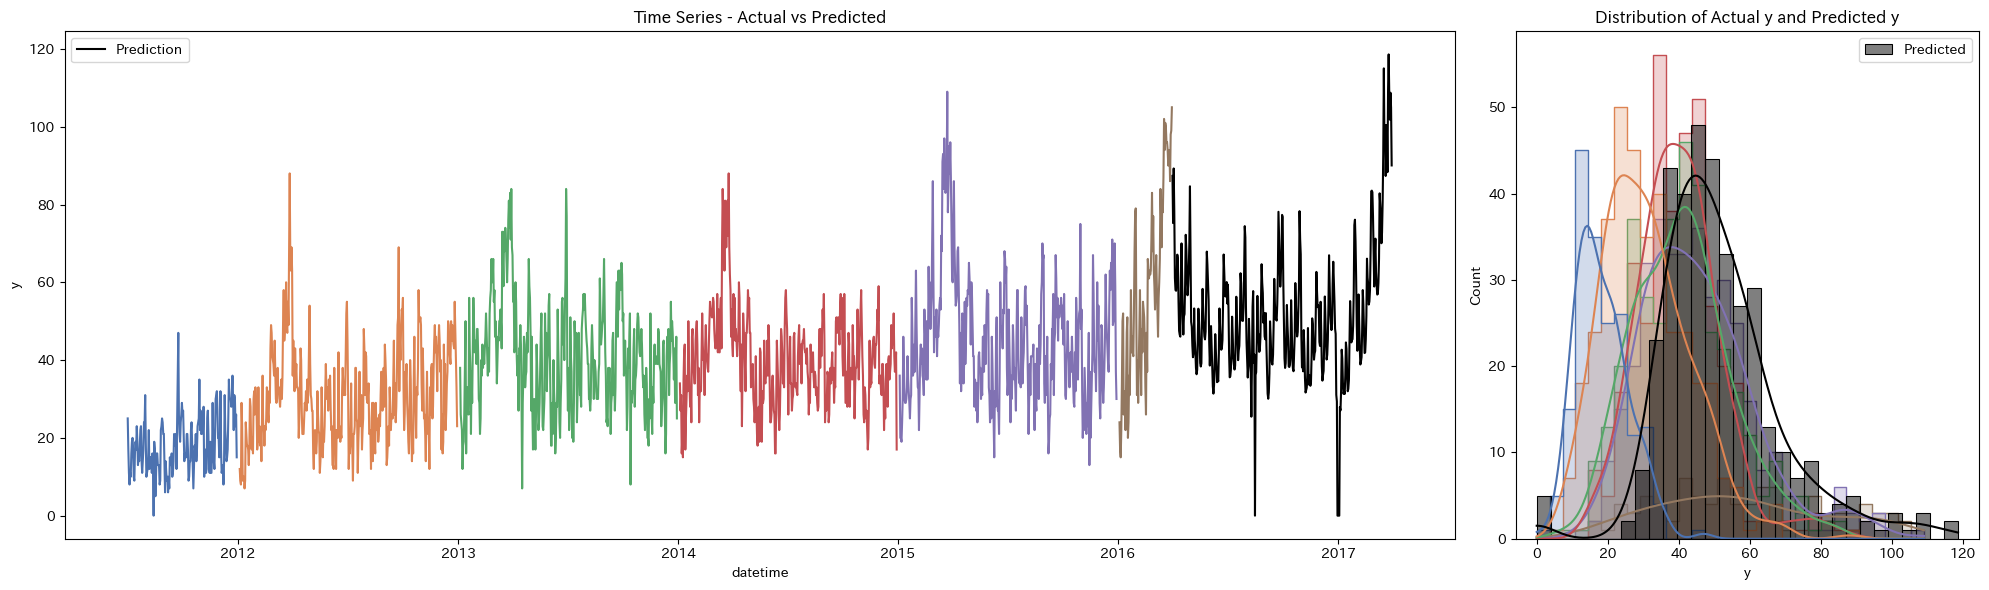

In [19]:
#LightGBMモデルで予測した yの値をグラフ化。割と各年の特徴をとらえている気がする。（signateスコアも10.56 から 9.2とかなりスコアが上がった！！）
test_x = test_x.copy()
test_x["y_pred"] = y_pred

# datetime列をtestから復元
test_x["datetime"] = test["datetime"].values



fig, axes = plt.subplots(1, 2, figsize=(20, 6), gridspec_kw={'width_ratios': [3, 1]})

# ---- 左側：時系列グラフ（予測値を色付きで）----
sns.lineplot(data=train, x="datetime", y="y", hue="year", palette="deep", ax=axes[0], legend=False)
sns.lineplot(data=test_x, x="datetime", y="y_pred", color="black", label="Prediction", ax=axes[0])

axes[0].set_title("Time Series - Actual vs Predicted")
axes[0].set_ylabel("y")
axes[0].legend()

# ---- 右側：ヒストグラム（予測分布を追加）----
sns.histplot(data=train, x="y", hue="year", bins=30, kde=True, palette="deep", ax=axes[1], element="step")
sns.histplot(test_x["y_pred"], color="black", bins=30, kde=True, label="Predicted", ax=axes[1])

axes[1].set_title("Distribution of Actual y and Predicted y")
axes[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
from pycaret.regression import *


# y列を含めた状態で PyCaret に渡すため、datetime のみを除外
train_x = train_x.drop(["datetime"], axis=1)



df_setup = setup(data=train_x,
                 target="y",
                 session_id=42,
                 fold_strategy= 'timeseries',
                 data_split_shuffle=False,
                 fold = 10,
                 imputation_type = "iterative",
                 numeric_iterative_imputer = "lightgbm",
                 normalize = False,
                 )

base_model = compare_models(sort='mae', errors='raise', n_select=3)

blend  = blend_models(base_model)

tune_blend = tune_model(blend)

final_model = finalize_model(tune_blend)

prediction_test_data = predict_model(final_model, data = test_x)

submit_df = pd.read_csv("sample_submit.csv", header=None)


# 予測値だけを取得
submit_df[1] = prediction_test_data["prediction_label"].values  # ←ここ重要

# 提出ファイルとして保存
submit_df.to_csv("submit1.csv", index=False , header=False)


prediction_test_data